<a href="https://colab.research.google.com/github/ArtuomMerkulov/ArtuomMerkulov/blob/main/%22%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BB%D0%B8%D1%86%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация скриншотов экранов мобильных игр
Для генерации использовал маску в качестве условия


In [1]:
!pip install keras==2.0 -q 
!pip install tensorflow==2.7.0 -q

     |████████████████████████████████| 191 kB 6.7 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 578.1 MB 8.0 kB/s 
     |████████████████████████████████| 578.1 MB 6.8 kB/s 
     |████████████████████████████████| 511.8 MB 25 kB/s 
     |████████████████████████████████| 511.7 MB 31 kB/s 
     |████████████████████████████████| 511.7 MB 211 bytes/s 
     |████████████████████████████████| 498.0 MB 13 kB/s 
     |████████████████████████████████| 498.4 MB 25 kB/s 
     |████████████████████████████████| 498.0 MB 20 kB/s 
     |████████████████████████████████| 498.0 MB 34 kB/s 
     |████████████████████████████████| 497.6 MB 2.0 kB/s 
     |████████████████████████████████| 496.0 MB 12 kB/s 
     |████████████████████████████████| 495.5 MB 18 kB/s 
     |████████████████████████████████| 495.5 MB 20 kB/s 
     |████████████████████████████████| 495.1 MB 9.0 kB/s 
     |████████████████████████████████| 489.6 MB 29 kB/s 
     |█

In [2]:
import scipy
import tensorflow as tf

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, LeakyReLU
from keras.layers import BatchNormalization, Add, add
from keras.layers import UpSampling2D, Conv2D
from keras.applications import vgg19
#from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import img_to_array, load_img
#from keras.models import Sequential, Model
from keras.models import Sequential, Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import keras.backend as K
from tqdm import tqdm
from tensorflow.python.platform.tf_logging import set_verbosity, FATAL
set_verbosity(FATAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/Numpy/Segmentation of faces.zip'

Archive:  /content/drive/MyDrive/Numpy/Segmentation of faces.zip
   creating: лица/
   creating: лица/ImageSets/
   creating: лица/ImageSets/Segmentation/
  inflating: лица/ImageSets/Segmentation/default.txt  
   creating: лица/JPEGImages/
  inflating: лица/JPEGImages/69000.png  
  inflating: лица/JPEGImages/69001.png  
  inflating: лица/JPEGImages/69002.png  
  inflating: лица/JPEGImages/69003.png  
  inflating: лица/JPEGImages/69004.png  
  inflating: лица/JPEGImages/69005.png  
  inflating: лица/JPEGImages/69006.png  
  inflating: лица/JPEGImages/69007.png  
  inflating: лица/JPEGImages/69008.png  
  inflating: лица/JPEGImages/69011.png  
  inflating: лица/labelmap.txt   
   creating: лица/SegmentationClass/
  inflating: лица/SegmentationClass/69000.png  
  inflating: лица/SegmentationClass/69001.png  
  inflating: лица/SegmentationClass/69002.png  
  inflating: лица/SegmentationClass/69003.png  
  inflating: лица/SegmentationClass/69004.png  
  inflating: лица/SegmentationClass/690

In [6]:
img_shape = (128, 256, 3) #размер изображения
height = img_shape[0]
width = img_shape[1]

In [7]:
imgs = [] 
for image in sorted(os.listdir('/content/лица/JPEGImages/')): #проходим по каждому файлу, получив список файлов в папке 
  print(image)
  imgs.append(img_to_array(load_img('/content/лица/JPEGImages/'+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
imgs = np.stack(imgs).astype('uint8') #сохраняем итоговый массив изображений

masks = []
for image in sorted(os.listdir('/content/лица/SegmentationObject/')): #проходим по каждому файлу, получив список файлов в папке 
  masks.append(img_to_array(load_img('/content/лица/SegmentationObject/'+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
masks = np.stack(masks).astype('uint8') #сохраняем итоговый массив масок

69000.png
69001.png
69002.png
69003.png
69004.png
69005.png
69006.png
69007.png
69008.png
69011.png


In [8]:
def build_generator():
    gf = 64 #минимальное число фильтров
    
    def conv2d(layer_input, filters, f_size=4, bn=True): #слой с понижением разрешения (encoder)
        
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #strides = 2 уменьшает разрешение в 2 раза при padding='same'
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0): #слой с повышением разрешения (decoder) принимает на вход предыдущий слой и skip-слой от encoder'а
        u = UpSampling2D(size=2)(layer_input) #увеличивам разрешение в 2 раза
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u) #strides=1, padding='same',  поэтому разрешение сохраняется
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input]) #соединяем skip-слой и слой decoder'а
        return u

    d0 = Input(shape=img_shape, name="condition") #входное изображение (условие)

    # Часть encoder'a
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4) #чем меньше размер карт активаций
    d4 = conv2d(d3, gf*8) #тем больше должно быть фильтров в сверточном слое
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Часть decoder'a
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8) 
    u3 = deconv2d(u2, d4, gf*8) #чем больше размер карт активаций
    u4 = deconv2d(u3, d3, gf*4) #тем меньше должно быть фильтров в сверточном слое
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', name='G_output')(u7) 

    return Model(d0, output_img, name="G")

In [9]:
gen = build_generator() #создаем генератор
gen.summary()

Model: "G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition (InputLayer)         [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 64)  3136        ['condition[0][0]']              
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 128, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 64, 128)  131200      ['leaky_re_lu[0][0]']            

In [10]:
def build_discriminator():
  
  df = 64 #минимальное число фильтров
  def d_layer(layer_input, filters, f_size=4, bn=True): #слой дискриминатора с понижением разрешения
      
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #размер карт активаций будет уменьшен в 2 раза, так как strides=2 при padding='same'
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

  image = Input(shape=img_shape, name="real_or_fake_A") #на вход дискриминатору подается либо реальное изображение, либо фейковое
  condition = Input(shape=img_shape, name="condition") #и дополнительно изображение-условие

  combined_imgs = Concatenate(axis=-1)([image, condition]) #объединяем оба входа в 1 слой

  d1 = d_layer(combined_imgs, df, bn=False)
  d2 = d_layer(d1, df*2)
  d3 = d_layer(d2, df*4) #уменьшаем размер карт активации, увеличивая их число
  d4 = d_layer(d3, df*8)

  validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='D_output', activation='sigmoid')(d4) #на выходе будет двумерный массив, каждый элемент которого определяет, подлинность части изображения (patch GAN)
                                                                                                            #0 отвечает за фейковые изображения, 1 за подлинные, поэтому используем sigmoid

  return Model([image, condition], validity, name='D')

In [11]:
dis = build_discriminator()
dis.summary()

Model: "D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 real_or_fake_A (InputLayer)    [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 condition (InputLayer)         [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_6 (Concatenate)    (None, 128, 256, 6)  0           ['real_or_fake_A[0][0]',         
                                                                  'condition[0][0]']              

In [12]:
def build_vgg():
  vgg_in = Input(img_shape)
  vgg = vgg19.VGG19(include_top=False, input_shape=img_shape, input_tensor=vgg_in) #скачиваем архитектуру и веса 
  vgg_out = vgg.get_layer('block5_conv4').output #получаем последний сверточный слой
  vgg = Model(vgg_in, vgg_out, name='vgg')
  vgg.trainable = False #модель уже предобучена, поэтому ее необходимо заморозить

  return vgg

In [13]:
vgg = build_vgg()
vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 128, 128)      147584    
                                                                

In [14]:
def build_gan(generator, discriminator, vgg):
  discriminator.trainable = False #замораживаем дискриминатор

  condition = Input(img_shape, name='Condition') #вход изображения-условия
  fake_img = generator(condition) #изображение, полученное от генератора

  fake_features = vgg(fake_img) #карты активации, полученные от фейкового изображения

  fake_validity = discriminator([fake_img, condition]) #соединяем генератор и дискриминатор

  gan = Model(condition, [fake_validity, fake_img, fake_features]) #получаем gan с тремя выходами: первый отвечает за "правдоподобность", второй за изображение от генератора, третий за карты активации

  return gan

In [15]:
dis.output_shape[1:]

(8, 16, 1)

In [16]:
(np.ones((512, *dis.output_shape[1:]))).shape

(512, 8, 16, 1)

In [17]:
def train(generator, discriminator, gan, vgg, imgs, masks, epochs, batch_size):

  for epoch in range(epochs): 
    idx = np.random.choice(imgs.shape[0], imgs.shape[0], replace=False) #перемешиваем индексы, чтобы batch'и всегда были разными

    with tqdm(total=imgs.shape[0]) as pbar: #для отслеживания создаем progressbar
      for batch in range(imgs.shape[0]//batch_size):
        y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
        y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2

        idx_batch = idx[batch*batch_size:(batch+1)*batch_size] #получаем индексы для одного batch'а

        real_imgs = (imgs[idx_batch]/127.5)-1 #получаем истинные изображения и нормализуем их
        condition = (masks[idx_batch]/127.5)-1 #получаем маски и нормализуем их

        fake_imgs = generator.predict(condition) #генерируем изображения по маскам

        #тренируем дискриминатор       
        d_loss_real = discriminator.train_on_batch([real_imgs, condition], y_real)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, condition], y_fake)
        d_loss_total = 0.5*np.add(d_loss_real, d_loss_fake)
   
        #тренируем генератор
        real_features = vgg.predict(real_imgs)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:]))

        g_loss = gan.train_on_batch(condition, [y_real, real_imgs, real_features])
        pbar.update(batch_size) #обновляем progressbar
        pbar.set_description("Epoch: {}/{}, Discriminator loss: {}, Generator loss:{}".format(epoch+1, epochs, d_loss_total[0], g_loss))

In [18]:
gen = build_generator() #создаем генератор

dis = build_discriminator() #создаем дискриминатор
dis.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, beta_1=0.5), metrics=['accuracy'])

vgg = build_vgg() #создаем vgg модель

gan = build_gan(gen, dis, vgg) #создаем gan
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=Adam(lr=1e-4, beta_1=0.5)) #вклад разницы между пикселями в 10 раз больше, чем вклад от feature loss и в 100 раз больше, чем вклад от GAN

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
gen.summary()

Model: "G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition (InputLayer)         [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 64, 128, 64)  3136        ['condition[0][0]']              
                                                                                                  
 leaky_re_lu_11 (LeakyReLU)     (None, 64, 128, 64)  0           ['conv2d_17[0][0]']              
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 64, 128)  131200      ['leaky_re_lu_11[0][0]']         

In [20]:
dis.summary()

Model: "D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 real_or_fake_A (InputLayer)    [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 condition (InputLayer)         [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_13 (Concatenate)   (None, 128, 256, 6)  0           ['real_or_fake_A[0][0]',         
                                                                  'condition[0][0]']              

In [21]:
vgg.summary()

Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 64, 128)       0       

In [30]:
train(gen, dis, gan, vgg, imgs, masks, 10, 10) 

Epoch: 1/10, Discriminator loss: 0.6956894397735596, Generator loss:[6.353089332580566, 0.7622761130332947, 0.050259679555892944, 0.05648449808359146]: 100%|██████████| 10/10 [00:00<00:00, 12.44it/s]
Epoch: 2/10, Discriminator loss: 0.7126437127590179, Generator loss:[6.121434688568115, 0.6948519945144653, 0.04873630777001381, 0.0552951879799366]: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s]
Epoch: 3/10, Discriminator loss: 0.6986749470233917, Generator loss:[5.595386505126953, 0.7254708409309387, 0.04337866231799126, 0.05320493504405022]: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]
Epoch: 4/10, Discriminator loss: 0.7123811841011047, Generator loss:[5.415537357330322, 0.696226954460144, 0.04196508601307869, 0.052280206233263016]: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s]
Epoch: 5/10, Discriminator loss: 0.6866492331027985, Generator loss:[5.461414813995361, 0.7193014621734619, 0.04229850694537163, 0.05122629553079605]: 100%|██████████| 10/10 [00:00<00:00, 15.07it/s]
Epoch

In [31]:
def sample_image(generator, imgs, masks, idx): 
    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    ax[0].imshow(masks[idx]) 
    ax[0].set_title('маска') # показываем маску
    
    condition = masks[idx]/127.5-1
    generated = (generator.predict(condition[None])+1)*127.5 

    ax[1].imshow(generated[0].astype('uint8')) #показываем сгенерированное изображение
    ax[1].set_title('сгенерированное изображение')

    ax[2].imshow(imgs[idx]) #показываем исходное изображение
    ax[2].set_title('реальное изображение')

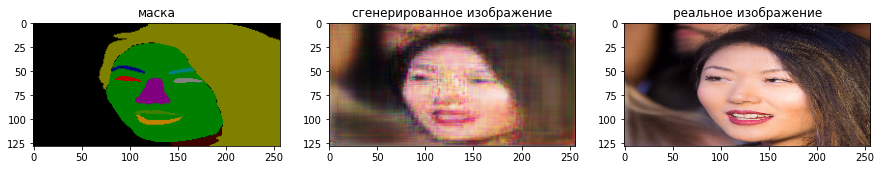

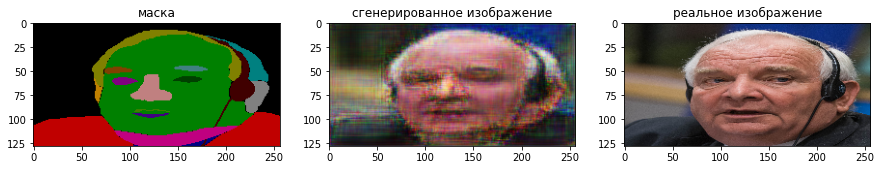

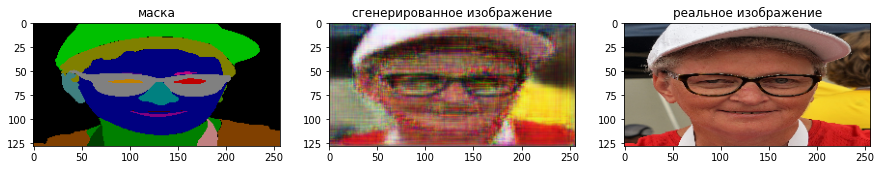

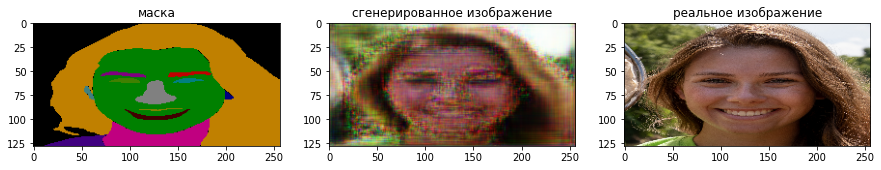

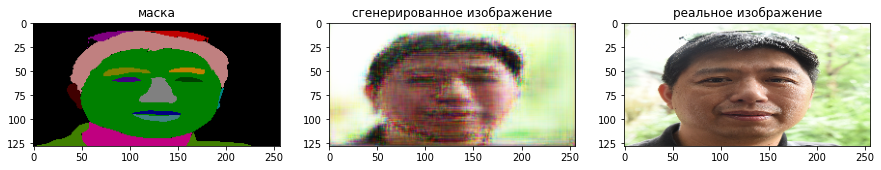

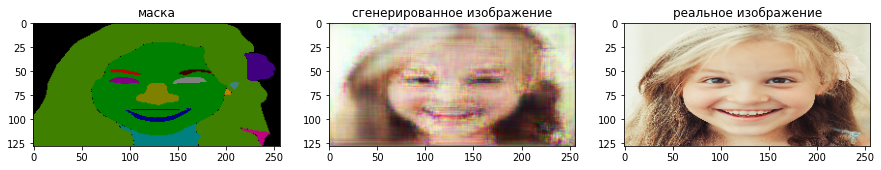

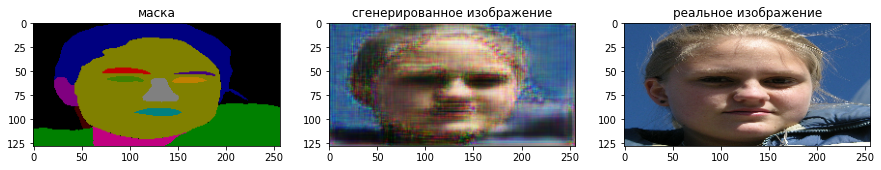

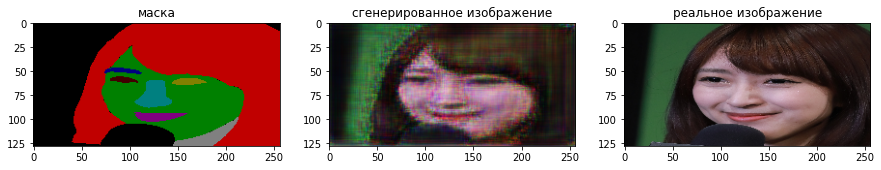

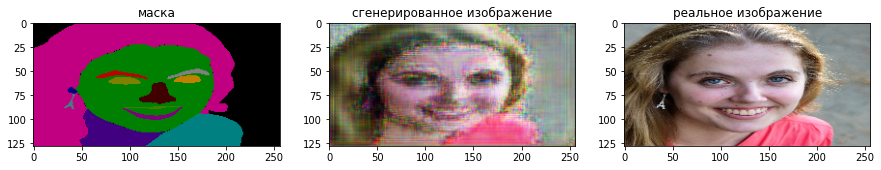

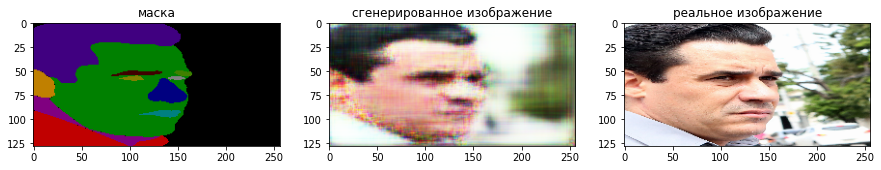

In [32]:
for i in [0,1,2,3,4,5,6,7,8,9]:
   sample_image(gen, imgs, masks, i)